In [4]:
# !pip install imbalanced-learn


In [5]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
from sklearn.svm import SVC
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [6]:
train_data = pd.read_csv('https://excelr.s3.nl-ams.scw.cloud/DataScience-Assignments/Assignments/SVM/SalaryData_Train%281%29.csv')
test_data = pd.read_csv('https://excelr.s3.nl-ams.scw.cloud/DataScience-Assignments/Assignments/SVM/SalaryData_Test%281%29.csv')

In [7]:
train_data.head()

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,Salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#### **EDA**

In [8]:
print(train_data.shape)
print(test_data.shape)

(30161, 14)
(15060, 14)


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30161 entries, 0 to 30160
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            30161 non-null  int64 
 1   workclass      30161 non-null  object
 2   education      30161 non-null  object
 3   educationno    30161 non-null  int64 
 4   maritalstatus  30161 non-null  object
 5   occupation     30161 non-null  object
 6   relationship   30161 non-null  object
 7   race           30161 non-null  object
 8   sex            30161 non-null  object
 9   capitalgain    30161 non-null  int64 
 10  capitalloss    30161 non-null  int64 
 11  hoursperweek   30161 non-null  int64 
 12  native         30161 non-null  object
 13  Salary         30161 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.2+ MB


In [10]:
train_data.describe()

,age,educationno,capitalgain,capitalloss,hoursperweek
count,30161.000000,30161.000000,30161.000000,30161.000000,30161.000000
mean,38.438115,10.121316,1092.044064,88.302311,40.931269
std,13.134830,2.550037,7406.466611,404.121321,11.980182
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [11]:
train_data.isna().sum()

age              0
workclass        0
education        0
educationno      0
maritalstatus    0
occupation       0
relationship     0
race             0
sex              0
capitalgain      0
capitalloss      0
hoursperweek     0
native           0
Salary           0
dtype: int64

#### **Data Visualization**

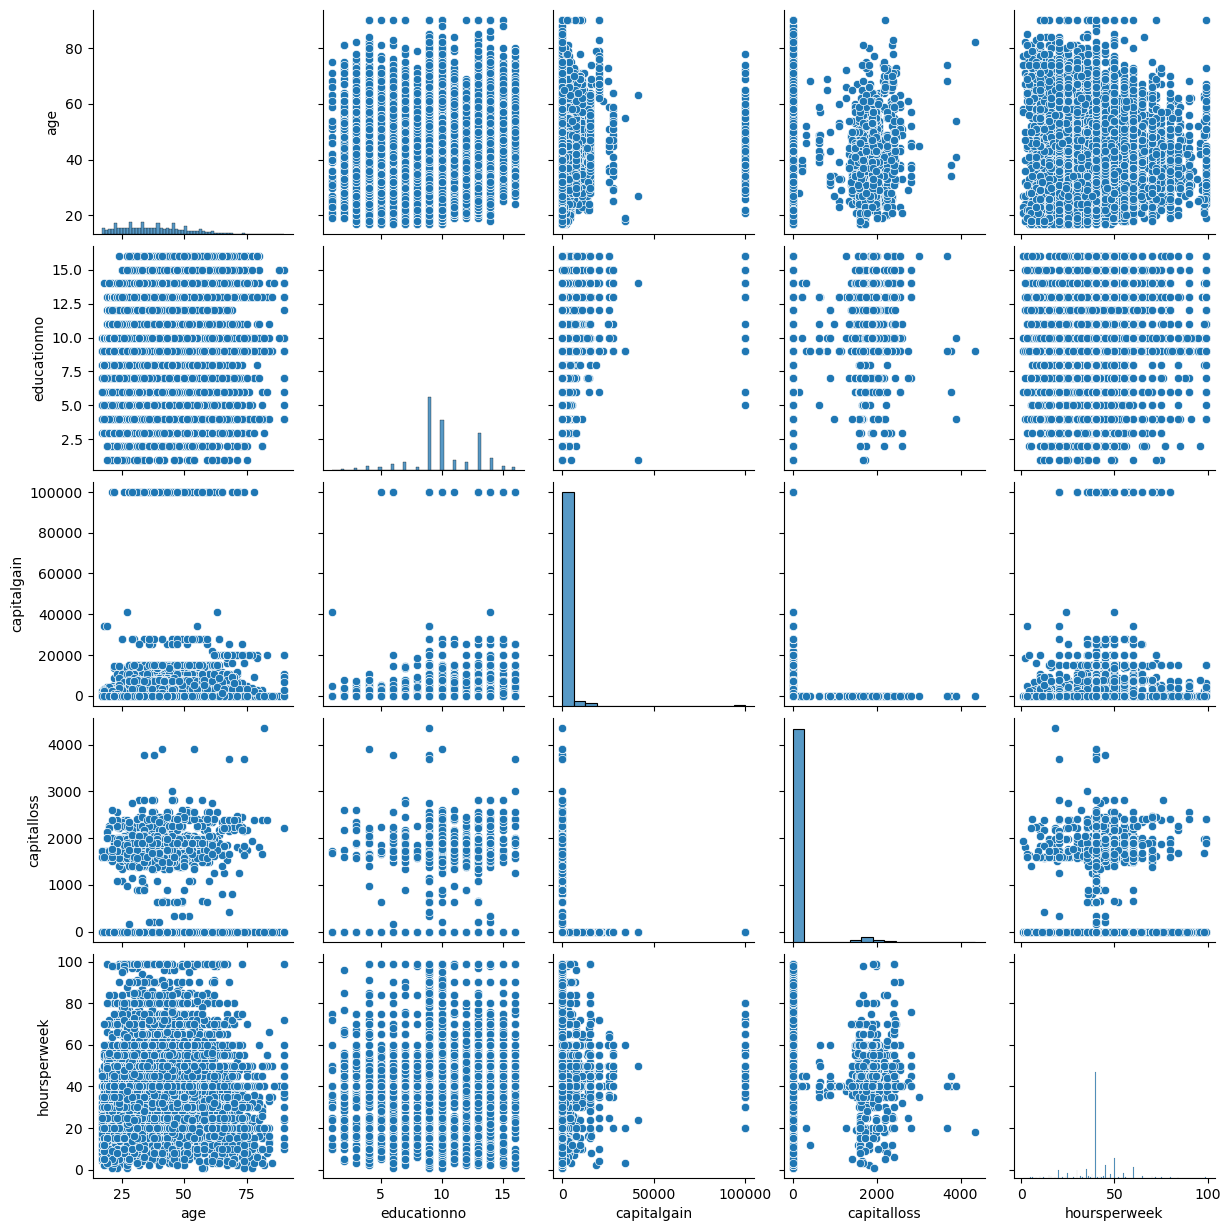

In [12]:
sns.pairplot(train_data)
plt.show()

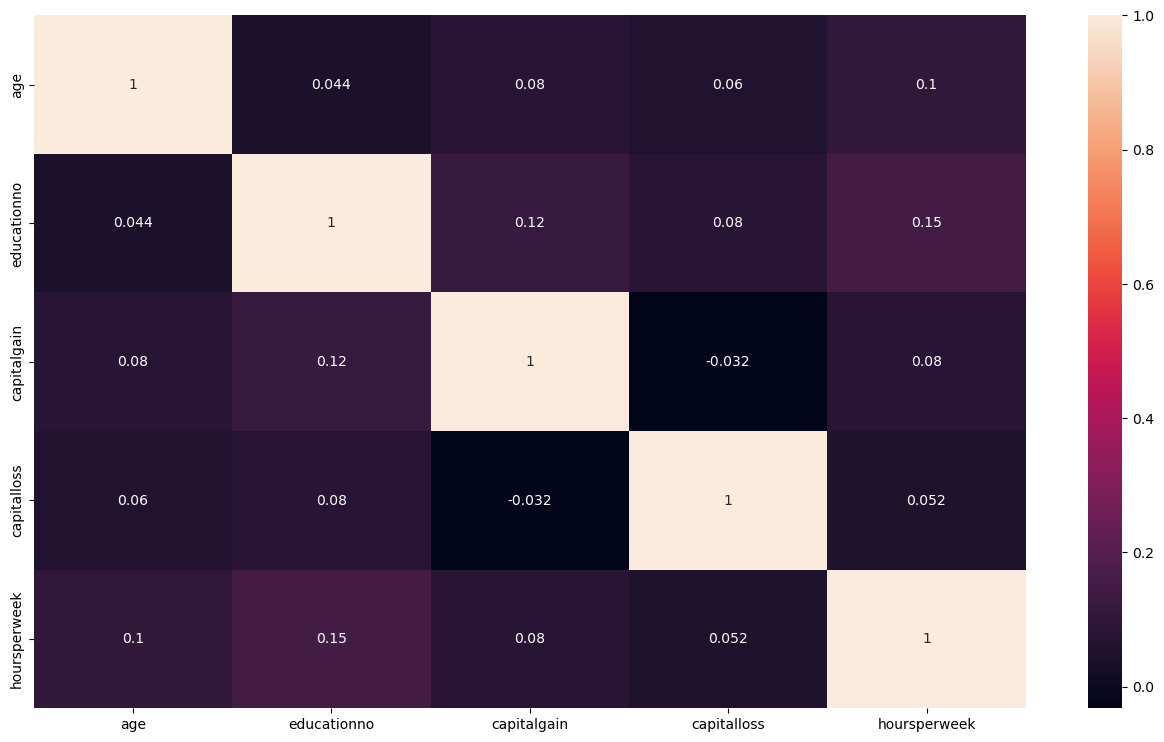

In [13]:
corr = train_data.corr()
sns.heatmap(corr, annot=True)
plt.show()

####  **Outliers Detection**

In [14]:
outlier1 = train_data.copy() 
fig, axes=plt.subplots(4,1,figsize=(12,7),sharex=False,sharey=False)
sns.boxplot(x='age',data=outlier1,palette='crest',ax=axes[0])
sns.boxplot(x='capitalgain',data=outlier1,palette='crest',ax=axes[1])
sns.boxplot(x='capitalloss',data=outlier1,palette='crest',ax=axes[2])
sns.boxplot(x='hoursperweek',data=outlier1,palette='crest',ax=axes[3])
plt.tight_layout(pad=2.0)

In [15]:
outlier2 = test_data.copy() 
fig, axes=plt.subplots(4,1,figsize=(12,7),sharex=False,sharey=False)
sns.boxplot(x='age',data=outlier2,palette='crest',ax=axes[0])
sns.boxplot(x='capitalgain',data=outlier2,palette='crest',ax=axes[1])
sns.boxplot(x='capitalloss',data=outlier2,palette='crest',ax=axes[2])
sns.boxplot(x='hoursperweek',data=outlier2,palette='crest',ax=axes[3])
plt.tight_layout(pad=2.0)

#### There are lot of outliers present in the dataframe but we can't drop them because they are present in a very large quantity and can be important for model building

#### **Data Preprocessing**

In [16]:
le=LabelEncoder()
train_data['workclass']=le.fit_transform(train_data['workclass'])
train_data['education']=le.fit_transform(train_data['education'])
train_data['maritalstatus']=le.fit_transform(train_data['maritalstatus'])
train_data['occupation']=le.fit_transform(train_data['occupation'])
train_data['relationship']=le.fit_transform(train_data['relationship'])
train_data['race']=le.fit_transform(train_data['race'])
train_data['sex']=le.fit_transform(train_data['sex'])
train_data['native']=le.fit_transform(train_data['native'])
train_data

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,Salary
0,39,5,9,13,4,0,1,4,1,2174,0,40,37,<=50K
1,50,4,9,13,2,3,0,4,1,0,0,13,37,<=50K
2,38,2,11,9,0,5,1,4,1,0,0,40,37,<=50K
3,53,2,1,7,2,5,0,2,1,0,0,40,37,<=50K
4,28,2,9,13,2,9,5,2,0,0,0,40,4,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30156,27,2,7,12,2,12,5,4,0,0,0,38,37,<=50K
30157,40,2,11,9,2,6,0,4,1,0,0,40,37,>50K
30158,58,2,11,9,6,0,4,4,0,0,0,40,37,<=50K
30159,22,2,11,9,4,0,3,4,1,0,0,20,37,<=50K


In [17]:
train_data['Salary']=[0 if i.strip()=='<=50K' else 1 for i in train_data['Salary']]

In [18]:
test_data['workclass']=le.fit_transform(test_data['workclass'])
test_data['education']=le.fit_transform(test_data['education'])
test_data['maritalstatus']=le.fit_transform(test_data['maritalstatus'])
test_data['occupation']=le.fit_transform(test_data['occupation'])
test_data['relationship']=le.fit_transform(test_data['relationship'])
test_data['race']=le.fit_transform(test_data['race'])
test_data['sex']=le.fit_transform(test_data['sex'])
test_data['native']=le.fit_transform(test_data['native'])
test_data

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,Salary
0,25,2,1,7,4,6,3,2,1,0,0,40,37,<=50K
1,38,2,11,9,2,4,0,4,1,0,0,50,37,<=50K
2,28,1,7,12,2,10,0,4,1,0,0,40,37,>50K
3,44,2,15,10,2,6,0,2,1,7688,0,40,37,>50K
4,34,2,0,6,4,7,1,4,1,0,0,30,37,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15055,33,2,9,13,4,9,3,4,1,0,0,40,37,<=50K
15056,39,2,9,13,0,9,1,4,0,0,0,36,37,<=50K
15057,38,2,9,13,2,9,0,4,1,0,0,50,37,<=50K
15058,44,2,9,13,0,0,3,1,1,5455,0,40,37,<=50K


In [19]:
test_data['Salary']=[0 if i.strip()=='<=50K' else 1 for i in test_data['Salary']]

#### **Model Building**

In [20]:
X_train = train_data.drop(['Salary'],axis=1)
y_train = train_data[['Salary']]

X_test = test_data.drop(['Salary'],axis=1)
y_test = test_data[['Salary']]

In [21]:
print('X_train Shape :', X_train.shape)
print('y_train Shape :', y_train.shape)
print('X_test Shape  :', X_test.shape)
print('y_test Shape  :', y_test.shape)

X_train Shape : (30161, 13)
y_train Shape : (30161, 1)
X_test Shape  : (15060, 13)
y_test Shape  : (15060, 1)


#### **Model Training | Testing | Evaluation - SVM Model**

In [22]:
svc = SVC()
svc.fit(X_train, y_train)

C:\Users\91814\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [23]:
y_pred = svc.predict(X_test)

In [24]:
print(confusion_matrix(y_test, y_pred))

[[10997   363]
 [ 2703   997]]


In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88     11360
           1       0.73      0.27      0.39      3700

    accuracy                           0.80     15060
   macro avg       0.77      0.62      0.64     15060
weighted avg       0.79      0.80      0.76     15060



In [26]:
svc.score(X_train, y_train)

0.7960279831570571

In [27]:
svc.score(X_test, y_test)

0.7964143426294821

#### **Handling Imbalance Data**

In [28]:
train_data['Salary'].value_counts()

0    22653
1     7508
Name: Salary, dtype: int64

In [29]:
sm = SMOTE()
X_resampled, y_resampled = sm.fit_resample(X_train,y_train)

In [30]:
X_resampled

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native
0,39,5,9,13,4,0,1,4,1,2174,0,40,37
1,50,4,9,13,2,3,0,4,1,0,0,13,37
2,38,2,11,9,0,5,1,4,1,0,0,40,37
3,53,2,1,7,2,5,0,2,1,0,0,40,37
4,28,2,9,13,2,9,5,2,0,0,0,40,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45301,47,2,10,13,2,12,0,4,1,0,0,18,37
45302,43,1,11,13,5,3,4,4,0,4934,0,40,37
45303,44,2,12,11,2,11,0,4,1,0,0,50,8
45304,30,2,13,11,2,3,0,4,1,15024,0,60,37


In [31]:
y_resampled

,Salary
0,0
1,0
2,0
3,0
4,0
...,...
45301,1
45302,1
45303,1
45304,1


In [32]:
y_resampled.value_counts()

Salary
0         22653
1         22653
dtype: int64

In [33]:
svc = SVC(C=2,gamma=0.01)
svc.fit(X_resampled,y_resampled)

C:\Users\91814\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=2, gamma=0.01)

In [34]:
y_pred=svc.predict(X_test)

In [35]:
print(confusion_matrix(y_test,y_pred))

[[9271 2089]
 [ 632 3068]]


In [36]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.82      0.87     11360
           1       0.59      0.83      0.69      3700

    accuracy                           0.82     15060
   macro avg       0.77      0.82      0.78     15060
weighted avg       0.85      0.82      0.83     15060



In [37]:
svc.score(X_resampled,y_resampled)

0.8706573080828146

In [ ]:
svc.score(X_test,y_test)

#### **Feature Selection**

In [ ]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [ ]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
    
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

### Features 1,2,5,7,8,12 are not highly relevant

In [ ]:
train_data_copy = train_data.copy()
train_data_copy.drop(train_data_copy.columns[[1,2,5,7,8,12]],axis=1,inplace=True)
train_data_copy

In [ ]:
X_train = train_data_copy.drop(['Salary'],axis=1)
y_train = train_data_copy[['Salary']]

In [ ]:
test_data_copy = test_data.copy()
test_data_copy.drop(test_data_copy.columns[[1,2,5,7,8,12]],axis=1,inplace=True)
test_data_copy

In [ ]:
X_test = test_data_copy.drop(['Salary'],axis=1)
y_test = test_data_copy[['Salary']]

#### **Model Training with Highly Relevant Features**

In [ ]:
svc=SVC(C=3.0, kernel='rbf', gamma=0.01, random_state=10)
svc.fit(X_train,y_train)

In [ ]:
y_pred=svc.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,y_pred))

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
svc.score(X_train,y_train)

In [ ]:
svc.score(X_test,y_test)